In [1]:
import os
import numpy as np
from PIL import Image

import random
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import torch.optim as optim

from torchvision import transforms
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

from diffusers import StableDiffusionInpaintPipeline, AutoencoderKL
import timm

class Denormalize(transforms.Normalize):
    def __init__(self, mean, std):
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        self.mean_rev = -mean / std
        self.std_rev = 1 / std
        super().__init__(mean=self.mean_rev, std=self.std_rev)

norm_dino = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
denorm_dino = Denormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

val_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    # normalize_img,
])

def load_img(path, transforms=None):
    img = Image.open(path).convert("RGB")
    img = transforms(img).unsqueeze(0).to(device)
    return img

def norm_tensor(tensor):
    t = tensor.clone().detach()
    
    min_val = t.min()
    max_val = t.max()

    tensor_norm = (tensor - min_val) / (max_val - min_val)

    print(f"Tensor normalized: min={tensor_norm.min()}, max={tensor_norm.max()}")
    
    return tensor_norm, min_val, max_val

def denorm_tensor(tensor, original_min=None, original_max=None):
    t = tensor.clone().detach()

    return t * (original_max - original_min) + original_min

def create_random_mask(img_pt, num_masks=1, mask_percentage=0.1, max_attempts=100):
    _, _, height, width = img_pt.shape
    mask_area = int(height * width * mask_percentage)
    masks = torch.zeros((num_masks, 1, height, width), dtype=img_pt.dtype)

    if mask_percentage >= 0.999:
        # Full mask for entire image
        return torch.ones((num_masks, 1, height, width), dtype=img_pt.dtype).to(img_pt.device)

    for ii in range(num_masks):
        placed = False
        attempts = 0
        while not placed and attempts < max_attempts:
            attempts += 1

            max_dim = int(mask_area ** 0.5)
            mask_width = random.randint(1, max_dim)
            mask_height = mask_area // mask_width

            # Allow broader aspect ratios for larger masks
            aspect_ratio = mask_width / mask_height if mask_height != 0 else 0
            if 0.25 <= aspect_ratio <= 4:  # Looser ratio constraint
                if mask_height <= height and mask_width <= width:
                    x_start = random.randint(0, width - mask_width)
                    y_start = random.randint(0, height - mask_height)
                    overlap = False
                    for jj in range(ii):
                        if torch.sum(masks[jj, :, y_start:y_start + mask_height, x_start:x_start + mask_width]) > 0:
                            overlap = True
                            break
                    if not overlap:
                        masks[ii, :, y_start:y_start + mask_height, x_start:x_start + mask_width] = 1
                        placed = True

        if not placed:
            # Fallback: just fill a central region if all attempts fail
            print(f"Warning: Failed to place mask {ii}, using fallback.")
            center_h = height // 2
            center_w = width // 2
            half_area = int((mask_area // 2) ** 0.5)
            h_half = min(center_h, half_area)
            w_half = min(center_w, half_area)
            masks[ii, :, center_h - h_half:center_h + h_half, center_w - w_half:center_w + w_half] = 1

    return masks.to(img_pt.device)

In [2]:
class Params:
    """Hyperparameters and configuration settings for FreqMark."""
    def __init__(self):
        # --- System & Paths ---
        self.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
        self.image_path = '/mnt/nas5/suhyeon/datasets/DIV2K_train_HR/0002.png'

        # --- Model Configurations ---
        self.vae_model_name = "stabilityai/stable-diffusion-2-1"
        self.vae_subfolder = "vae"
        self.dino_model_repo = 'facebookresearch/dinov2'
        self.dino_model_name = 'dinov2_vits14'
        
        # --- Image Size Parameters ---
        self.vae_image_size = 512
        self.dino_image_size = 224
        self.transform = transforms.Compose([
            transforms.Resize(self.vae_image_size),
            transforms.CenterCrop(self.vae_image_size),
            transforms.ToTensor(),
        ])

        # --- FreqMark Core Parameters ---
        self.message_bits = 2
        self.feature_dim = 192
        self.margin = 1.0
        self.grid_size = 28
        # self.num_patches = self.grid_size*self.grid_size

        # --- Optimization Parameters ---
        self.lr = 2.0
        self.steps = 400
        self.lambda_p = 0.05
        self.lambda_i = 0.25

        # --- Robustness Parameters ---
        self.eps1_std = 0.25 
        self.eps2_std = 0.06
        
        # --- Demo/Evaluation Parameters ---
        self.batch_size = 4
        self.num_test_images = 1

In [3]:
class FreqMark:
    def __init__(self, args):
        self.args = args

        # Initialize networks
        # self.vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae").to(self.args.device)
        # self.image_encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(self.args.device)
        self.image_encoder = timm.create_model(
            'convnext_tiny',
            pretrained=True,
            features_only=True,
        ).to(self.args.device)
        self.pipe = StableDiffusionInpaintPipeline.from_pretrained(
            "sd-legacy/stable-diffusion-inpainting",
            # torch_dtype=torch.float16,
            cache_dir='/mnt/nas5/suhyeon/caches'
        ).to(self.args.device)

        # Freeze all networks
        # for param in self.vae.parameters():
        #     param.requires_grad = False
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.pipe.vae.requires_grad_(False)
        self.pipe.unet.requires_grad_(False)
        self.pipe.text_encoder.requires_grad_(False)
        self.pipe.vae.eval()
        self.pipe.unet.eval()
        self.pipe.text_encoder.eval()

        self.pipe.set_progress_bar_config(disable=True)
        
        # Pre-define direction vectors
        # self.direction_vectors = torch.load('./sensitive_vec.pt')
        # self.direction_vectors = torch.randn(self.args.feature_dim)
        # self.direction_vectors = F.normalize(self.direction_vectors, p=2, dim=0)
        # self.direction_vectors = self.direction_vectors.unsqueeze(0).to(self.args.device)
        # torch.save(self.direction_vectors, './random_vec.pt')
        self.direction_vectors = torch.load('./random_vec.pt').to(self.args.device)
    
        self.mu = self.args.margin      # Hinge loss margin
        self.num_patches = (self.args.dino_image_size // 14) ** 2
        # self.secret_key = torch.randint(0, 2, (1, self.num_patches, 1), device=self.args.device) * 2 - 1 # {-1, 1}
        # self.secret_key = torch.randint(0, 2, (1, args.grid_size*args.grid_size, 1), device=self.args.device) * 2 - 1 # {-1, 1}
        # self.secret_key = torch.zeros((1, args.grid_size*args.grid_size, 1), dtype=torch.int, device=self.args.device)# {-1, 1}
        # torch.save(self.secret_key, './secret_key.pt')
        # self.secret_key = torch.load('./secret_key.pt').to(self.args.device)


    # def _init_direction_vectors(self) -> torch.Tensor:
    #     """Initialize direction vectors as described in paper"""
    #     # binary bit for each patch
    #     # vectors = torch.zeros(1, self.args.feature_dim)
    #     # for i in range(1):
    #     #     vectors[i, self.args.feature_dim-1] = 1.0  # One-hot encoding
    #     # print(vectors)
    #     # return vectors.to(self.args.device)
    #     # random_vector = torch.randn(self.args.feature_dim, device=self.args.device)
    #     # normalized_vector = F.normalize(random_vector, p=2, dim=0)
    #     # return normalized_vector.unsqueeze(0)
    #     self.direction_vectors = torch.load('./insensitive_vec.pt')

    def norm_tensor(self, tensor):
        t = tensor.clone().detach()
        
        min_val = t.min()
        max_val = t.max()

        tensor_norm = (tensor - min_val) / (max_val - min_val)

        # print(f"Tensor normalized: min={tensor_norm.min()}, max={tensor_norm.max()}")
        
        return tensor_norm, min_val, max_val

    def denorm_tensor(self, tensor, original_min=None, original_max=None):
        t = tensor.clone().detach()

        return t * (original_max - original_min) + original_min

    def _create_random_mask(self, img_pt, num_masks=1, mask_percentage=0.1, max_attempts=100):
        _, _, height, width = img_pt.shape
        mask_area = int(height * width * mask_percentage)
        masks = torch.zeros((num_masks, 1, height, width), dtype=img_pt.dtype)

        if mask_percentage >= 0.999:
            # Full mask for entire image
            return torch.ones((num_masks, 1, height, width), dtype=img_pt.dtype).to(img_pt.device)

        for ii in range(num_masks):
            placed = False
            attempts = 0
            while not placed and attempts < max_attempts:
                attempts += 1

                max_dim = int(mask_area ** 0.5)
                mask_width = random.randint(1, max_dim)
                mask_height = mask_area // mask_width

                # Allow broader aspect ratios for larger masks
                aspect_ratio = mask_width / mask_height if mask_height != 0 else 0
                if 0.25 <= aspect_ratio <= 4:  # Looser ratio constraint
                    if mask_height <= height and mask_width <= width:
                        x_start = random.randint(0, width - mask_width)
                        y_start = random.randint(0, height - mask_height)
                        overlap = False
                        for jj in range(ii):
                            if torch.sum(masks[jj, :, y_start:y_start + mask_height, x_start:x_start + mask_width]) > 0:
                                overlap = True
                                break
                        if not overlap:
                            masks[ii, :, y_start:y_start + mask_height, x_start:x_start + mask_width] = 1
                            placed = True

            if not placed:
                # Fallback: just fill a central region if all attempts fail
                print(f"Warning: Failed to place mask {ii}, using fallback.")
                center_h = height // 2
                center_w = width // 2
                half_area = int((mask_area // 2) ** 0.5)
                h_half = min(center_h, half_area)
                w_half = min(center_w, half_area)
                masks[ii, :, center_h - h_half:center_h + h_half, center_w - w_half:center_w + w_half] = 1

        return masks.to(img_pt.device)

    def vae_recon(self, image: torch.Tensor, iter: int):
        """VAE reconstruction. Inputs are outputs are 512x512"""
        latent = self.vae.encode(2*image-1).latent_dist.sample()
        reconstructed = self.vae.decode(latent).sample
        reconstructed = (reconstructed + 1) / 2
        for _ in range(iter-1):
            latent = self.vae.encode(2*reconstructed-1).latent_dist.sample()
            reconstructed = self.vae.decode(latent).sample
            reconstructed = (reconstructed + 1) / 2
        return reconstructed

    def embed_watermark(self, original: torch.Tensor, img_size: int) -> torch.Tensor:
        """
        Embed watermark in image using latent frequency space optimization
        
        Args:
            image: Input image tensor [B, C, H, W]
            message: Binary message {-1, 1} [B, message_bits]
        
        Returns:
            Watermarked image tensor
        """

        image = original.to(self.args.device)
        # message = message.to(self.device)

        # prompt_embeds = self.pipe._encode_prompt([""], self.args.device, 1, True, None)
        self.pipe.scheduler.set_timesteps(self.args.num_inference_steps, device=self.args.device)
        timesteps = self.pipe.scheduler.timesteps
        target_steps = timesteps[-40:]
        
        generator = torch.Generator(device="cpu").manual_seed(self.args.seed)
        noise_generator = torch.Generator(device=self.args.device).manual_seed(self.args.seed)

        # Step 1: Encode image to latent space
        # image = F.interpolate(original, size=(self.args.vae_image_size, self.args.vae_image_size), mode="bilinear", align_corners=False)
        latent = self.pipe.vae.encode(2*image-1).latent_dist.sample(generator=noise_generator) # [-1, 1], [B,4,64,64]
        latent = latent * self.pipe.vae.config.scaling_factor

        # Step 2: Transform to frequency domain
        latent_fft = torch.fft.fft2(latent, dim=(-2, -1)).detach()
        
        # Step 3: Initialize perturbation (trainable parameter)
        delta_m = torch.zeros_like(latent_fft, requires_grad=True)
        optimizer = optim.Adam([delta_m], lr=self.args.lr)

        epsilon = torch.randn(latent.shape, generator=noise_generator, device=self.args.device, dtype=latent.dtype).detach()
        epsilon_prime = torch.randn(latent.shape, generator=noise_generator, device=self.args.device, dtype=latent.dtype).detach()
        
        # Training loop
        # for step in range(self.args.steps):
        for step in tqdm(range(self.args.steps), desc="Embedding Watermark"):
            optimizer.zero_grad()

            mask = self._create_random_mask(image, num_masks=1, mask_percentage=self.args.mask_percentage)
            if random.random() < 0.5:
                mask = 1 - mask

            perturbed_fft = latent_fft + delta_m
            watermarked_latent = torch.fft.ifft2(perturbed_fft, dim=(-2, -1)).real
            watermarked_latent_vis = watermarked_latent / self.pipe.vae.config.scaling_factor
            watermarked_image = self.pipe.vae.decode(watermarked_latent_vis).sample
            watermarked_image = (watermarked_image + 1) / 2

            masked = watermarked_image * mask + (1 - mask) * image

            # watermarked_latent = watermarked_latent * self.pipe.vae.config.scaling_factor
            
            inpaint_mask_latent = F.interpolate(1-mask, size=(latent.shape[2], latent.shape[3]))
            inpaint_mask_latent = (inpaint_mask_latent > 0.65).to(dtype=latent.dtype)

            # start_index = len(timesteps) - 3
            # end_index = len(timesteps) - 1
            # random_index = torch.randint(start_index, end_index, (1,), generator=generator).item()
            # target_timestep = timesteps[random_index]
            
            # with torch.no_grad():
            #     epsilon = torch.randn(watermarked_latent.shape, generator=noise_generator, device=self.args.device, dtype=watermarked_latent.dtype)
            #     epsilon_prime = torch.randn(watermarked_latent.shape, generator=noise_generator, device=self.args.device, dtype=watermarked_latent.dtype)
            current_latent = self.pipe.scheduler.add_noise(watermarked_latent, epsilon, target_steps[0])

            for t in target_steps:
                simulated_noise_pred = epsilon * (1 - inpaint_mask_latent) + epsilon_prime * inpaint_mask_latent
                # current_latent = self.pipe.scheduler.add_noise(simulated_noise_pred, t, current_latent)
                x_prev = self.pipe.scheduler.step(simulated_noise_pred, t, current_latent, return_dict=False)[0]
                current_latent = x_prev

            attacked_latent = current_latent

            img_edit = self.pipe.vae.decode(1 / self.pipe.vae.config.scaling_factor * attacked_latent).sample
            img_edit = (img_edit + 1) / 2
            img_edit = img_edit.clamp(0, 1)

            img_edit_loc = norm_dino(img_edit)
            masked_loc = norm_dino(masked)
            # masked_1 = norm_dino(masked_1)

            # k = self.args.dino_image_size//self.args.grid_size
            # k = int(self.args.vae_image_size // 8)
            # mask_down = F.interpolate(mask, size=(k, k), mode="bilinear", align_corners=False)
            # gt_mask_patch = gt_mask_patch.view(1, self.args.grid_size*self.args.grid_size, 1)
            # gt_mask_patch = F.avg_pool2d(mask, kernel_size=k, stride=k).view(1, self.args.grid_size*self.args.grid_size, 1)

            loss_m = self._mask_loss(img_edit_loc, mask)
            loss_d = self._dice_loss(img_edit_loc, mask)
            loss_m1 = self._mask_loss(masked_loc, mask)
            loss_d1 = self._dice_loss(masked_loc, mask)
            # loss_auth = self._absolute_auth_loss(masked, gt_mask_patch)
            # loss_auth1 = self._absolute_auth_loss(masked_1, gt_mask_patch)

            ## related to secret key
            # k = self.args.dino_image_size//self.args.grid_size
            # gt_mask_patch = F.avg_pool2d(mask, kernel_size=k, stride=k).view(1, self.args.grid_size*self.args.grid_size, 1)

            # # features = self.image_encoder.get_intermediate_layers(watermarked_image)[0]
            # features = self.image_encoder(watermarked_image)[1] # [B, 384, 14, 14]
            # B, C, H, W = features.shape
            # features = features.permute(0, 2, 3, 1).view(B, H * W, C)
            # dot_products = torch.matmul(features, self.direction_vectors.T)
            # # loss_auth = self._auth_loss(dot_products, self.secret_key, gt_mask_patch)
            # loss_auth = self._absolute_auth_loss(dot_products, gt_mask_patch)
            
            # # features_1 = self.image_encoder.get_intermediate_layers(masked_1)[0]
            # features_1 = self.image_encoder(masked_1)[1]
            # B, C, H, W = features_1.shape
            # features_1 = features_1.permute(0, 2, 3, 1).view(B, H * W, C)
            # dot_products_1 = torch.matmul(features_1, self.direction_vectors.T)
            # # loss_auth_1 = self._auth_loss(dot_products_1, self.secret_key, gt_mask_patch)
            # loss_auth_1 = self._absolute_auth_loss(dot_products_1, gt_mask_patch)

            # watermarked_image = denorm_dino(watermarked_image)
            # masked = denorm_dino(masked)
            # masked_1 = denorm_dino(masked_1)
            # img_edit_loc = denorm_dino(img_edit_loc)

            loss_psnr = self._psnr_loss(watermarked_image, image)
            loss_lpips = self._lpips_loss(watermarked_image, image)

            # total_loss = (loss_m + loss_m1 + # loss_m2 + #loss_m3 + 
            #     loss_d + loss_d1 +
            #     self.args.lambda_p * loss_psnr + 
            #     self.args.lambda_i * loss_lpips)

            # if step < 200:
            #     auth_loss_weight = 1.0
            #     shape_loss_weight = 0.0
            # else:  # Stage 2: Key Embedding
            #     auth_loss_weight = 1.0 
            #     shape_loss_weight = 1.0

            # auth_loss_weight = 0.5
            # shape_loss_weight = 1.0

            # Combined loss (Equation 10 from paper)
            # total_loss = auth_loss_weight * (loss_auth + loss_auth_1) + \
            #              shape_loss_weight * (loss_m + loss_m1 + loss_d + loss_d1) + \
            #              self.args.lambda_p * loss_psnr + \
            #              self.args.lambda_i * loss_lpips

            clean_weight = 1.0
            noisy_weight = 1.0
            
            total_loss = noisy_weight * (loss_m + loss_d) + \
                         clean_weight * (loss_m1 + loss_d1) + \
                         self.args.lambda_p * loss_psnr + \
                         self.args.lambda_i * loss_lpips
            
            total_loss.backward()
            optimizer.step()

            if step == 0 or (step+1) % 100 == 0:
                psnr_val = self._compute_psnr(watermarked_image.detach(), image.detach())
                print(f"Step {step+1}, Loss: {total_loss.item():.4f}, PSNR: {psnr_val:.2f}")
                print(f"Mask Loss: {loss_m.item():.4f}, DICE Loss: {loss_d.item():.4f}")
                print(f"Mask1 Loss: {(loss_m1).item():.4f}, DICE1 Loss: {loss_d1.item():.4f}")
                # print(f"Auth Loss: {(loss_auth).item():.4f}, Auth1 Loss: {loss_auth1.item():.4f}")
                print(f"PSNR Loss: {loss_psnr.item():.4f}, LPIPS Loss: {loss_lpips.item():.4f}")

                # # Save images for analysis
                torchvision.utils.save_image(watermarked_image.detach(), os.path.join(args.output_dir, f"analysis_dist_wm_step{step+1}.png"))
                torchvision.utils.save_image(img_edit.detach(), os.path.join(args.output_dir, f"analysis_dist_inpaint_step{step+1}.png"))
                # # torchvision.utils.save_image(masked.detach(), os.path.join(args.output_dir, f"analysis_dist_masked_step{step+1}.png"))
                # # torchvision.utils.save_image(masked_1.detach(), os.path.join(args.output_dir, f"analysis_dist_masked1_step{step+1}.png"))

                sig_w = torch.sigmoid(self.decode_watermark(watermarked_image.detach())).cpu().numpy().flatten()
                sig_e = torch.sigmoid(self.decode_watermark(img_edit.detach())).cpu().numpy().flatten()
                # # sig_m = torch.sigmoid(self.decode_watermark(masked.detach())).cpu().numpy().flatten()
                # # sig_m1 = torch.sigmoid(self.decode_watermark(masked_1.detach())).cpu().numpy().flatten()

                print(f"[A: Watermarked] Mean: {sig_w.mean():.2f}, Std: {sig_w.std():.2f}, Min: {sig_w.min():.2f}, Max: {sig_w.max():.2f}")
                print(f"[B: Inpaint] Mean: {sig_e.mean():.2f}, Std: {sig_e.std():.2f}, Min: {sig_e.min():.2f}, Max: {sig_e.max():.2f}")
                # print(f"[B: Spliced] Mean: {sig_m.mean():.2f}, Std: {sig_m.std():.2f}, Min: {sig_m.min():.2f}, Max: {sig_m.max():.2f}")
                # print(f"[C: Noisy Spliced] Mean: {sig_m1.mean():.2f}, Std: {sig_m1.std():.2f}, Min: {sig_m1.min():.2f}, Max: {sig_m1.max():.2f}")

                plt.figure(figsize=(10, 6))
                plt.hist(sig_w, bins=50, alpha=0.5, label='A: Watermarked')
                plt.hist(sig_e, bins=50, alpha=0.5, label='B: Inpaint')
                # plt.hist(sig_m, bins=50, alpha=0.5, label='B: Spliced')
                # plt.hist(sig_m1, bins=50, alpha=0.5, label='C: Noisy Spliced')
                plt.title(f'Logit Distribution Comparison: Step {step+1}')
                plt.xlabel('Logit Value')
                plt.ylabel('Frequency')
                plt.legend()
                plt.grid(True)
                plt.savefig(os.path.join(args.output_dir, f"analysis_dist_step{step+1}.png"), bbox_inches='tight')

        # Final watermarked image
        final_fft = latent_fft + delta_m
        final_latent = torch.fft.ifft2(final_fft, dim=(-2, -1)).real
        final_watermarked = self.pipe.vae.decode(1 / self.pipe.vae.config.scaling_factor * final_latent).sample
        final_watermarked = (final_watermarked + 1) / 2
        final_watermarked = final_watermarked.clamp(0, 1)
        
        return final_watermarked.detach()
    
    def decode_watermark(self, watermarked_image: torch.Tensor) -> torch.Tensor:
        """
        Decode watermark from image using pre-trained image encoder
        
        Args:
            watermarked_image: Watermarked image tensor [B, C, H, W]
        
        Returns:
            Decoded message {-1, 1} [B, message_bits]
        """
        watermarked_image = watermarked_image.to(self.args.device)
        
        with torch.no_grad():
            # Extract features using image encoder
            # features = self.image_encoder(watermarked_image) # [1, 256, 384]
            watermarked_image = norm_dino(watermarked_image) 
            # features = self.image_encoder.get_intermediate_layers(watermarked_image)[0] # [1, 256, 384]
            features = self.image_encoder(watermarked_image)[1]
            B, C, H, W = features.shape
            features = features.permute(0, 2, 3, 1).view(B, H * W, C)
            # Compute dot products with direction vectors
            dot_products = torch.matmul(features, self.direction_vectors.T) # [1, 256, 384]*[1, 384, 256] -> [1, 256, 1]
            # agreement_scores = dot_products * self.secret_key

            B = dot_products.shape[0]
            H = W = int(dot_products.shape[1] ** 0.5)
            grid = dot_products.view(B, H, W).unsqueeze(0) # [1, 256, 1] -> [1, 1, 16, 16]
            grid = F.interpolate(grid, size=self.args.vae_image_size, mode='bilinear', align_corners=False)
        return grid
    
    def _message_loss(self, watermarked_image: torch.Tensor, message: torch.Tensor) -> torch.Tensor:
        """Hinge loss for message embedding (Equation 7)"""
        features = self.image_encoder(watermarked_image)
        dot_products = torch.matmul(features, self.direction_vectors.T)
        
        # Hinge loss with margin
        projections = dot_products * message
        loss = torch.clamp(self.mu - projections, min=0).mean()
        
        return loss
    
    def _mask_loss(self, watermarked_image: torch.Tensor, gt_mask: torch.Tensor) -> torch.Tensor:
        """
        Computes the loss based on patch-wise watermark detection to enforce a global watermark presence.
        The ground truth mask is implicitly all-ones, meaning the loss is minimized when all patches
        correctly embed the watermark.
        """
        # image_for_dino = F.interpolate(watermarked_image, 
        #                                size=(self.args.dino_image_size, self.args.dino_image_size), 
        #                                mode="bilinear", align_corners=False)

        # features = self.image_encoder.get_intermediate_layers(watermarked_image)[0] # [B, Num_Patches, Feature_Dim]
        features = self.image_encoder(watermarked_image)[1]
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1).view(B, H * W, C)
        dot_products = torch.matmul(features, self.direction_vectors.T)
        # agreement_scores = dot_products * self.secret_key
        B = dot_products.shape[0]
        H = W = int(dot_products.shape[1] ** 0.5)
        grid = dot_products.view(B, H, W).unsqueeze(0)
        # grid = dot_products.view(self.args.grid_size, self.args.grid_size).unsqueeze(0).unsqueeze(0) # [1, 256, 1] -> [1, 1, 14, 14]
        grid = F.interpolate(grid, size=self.args.vae_image_size, mode='bilinear', align_corners=False) # [B, Num_Patches, Feature_Dim]*[B, Feature_Dim, 1] = [B, Num_Patches, 1]
        loss = F.binary_cross_entropy_with_logits(grid, gt_mask)
        return loss
    
    def _psnr_loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """Negative PSNR loss (Equation 5)"""
        mse = F.mse_loss(pred, target)
        psnr = -10 * torch.log10(mse + 1e-8)
        return -psnr  # Negative for minimization
    
    def _lpips_loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """Simplified LPIPS-like loss"""
        # Simplified perceptual loss using L2 in feature space
        pred_gray = 0.299 * pred[:, 0] + 0.587 * pred[:, 1] + 0.114 * pred[:, 2]
        target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
        return F.mse_loss(pred_gray, target_gray)
    
    def _compute_psnr(self, pred: torch.Tensor, target: torch.Tensor) -> float:
        """Compute PSNR between images"""
        mse = F.mse_loss(pred, target).item()
        if mse == 0:
            return 100.0
        return 20 * np.log10(1.0 / np.sqrt(mse))
    
    def _dice_loss(self, watermarked_image, gt_mask, smooth=1e-5):
        # image_for_dino = F.interpolate(watermarked_image, 
        #                                size=(self.args.dino_image_size, self.args.dino_image_size), 
        #                                mode="bilinear", align_corners=False)

        # features = self.image_encoder.get_intermediate_layers(image_for_dino)[0] # [B, Num_Patches, Feature_Dim]
        features = self.image_encoder(watermarked_image)[1]
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1).view(B, H * W, C)
        dot_products = torch.matmul(features, self.direction_vectors.T)
        # agreement_scores = dot_products * self.secret_key
        B = dot_products.shape[0]
        H = W = int(dot_products.shape[1] ** 0.5)
        grid = dot_products.view(B, H, W).unsqueeze(0)
        # grid = dot_products.view(self.args.grid_size, self.args.grid_size).unsqueeze(0).unsqueeze(0) # [1, 256, 1] -> [1, 1, 14, 14]
        grid = F.interpolate(grid, size=self.args.vae_image_size, mode='bilinear', align_corners=False) # [B, Num_Patches, Feature_Dim]*[B, Feature_Dim, 1] = [B, Num_Patches, 1]
        
        pred = torch.sigmoid(grid) # Logits to probabilities

        # Flatten label and prediction tensors
        pred = pred.view(-1)
        target = gt_mask.view(-1)
        
        intersection = (pred * target).sum()
        dice_coeff = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
        return 1 - dice_coeff

    # def _auth_loss(self, dot_products, secret_key, gt_mask, margin=1.5):
    #     projections = dot_products * secret_key
    #     loss = torch.clamp(margin - projections, min=0)
    #     loss = (loss * gt_mask).mean()
    #     return loss
    
    # def _auth_loss(self, dot_products, secret_key, gt_mask):
    #     TARGET_SCORE = 5.0
    #     target_scores = secret_key * TARGET_SCORE
    #     loss = F.mse_loss(dot_products, target_scores, reduction='none')
    #     # loss = F.l1_loss(dot_products, target_scores, reduction='none')
    #     loss = (loss * gt_mask).mean()
    #     return loss
    
    def _absolute_auth_loss(self, image, gt_mask, TARGET_SCORE = 3.0):
        features = self.image_encoder(image)[1]
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1).view(B, H * W, C)
        dot_products = torch.matmul(features, self.direction_vectors.T)
        target_map = gt_mask * TARGET_SCORE + (1 - gt_mask) * (-1 * TARGET_SCORE)
        loss = F.l1_loss(dot_products, target_map)
        return loss
    
    def compute_bit_accuracy(self, original_message: torch.Tensor, 
                           decoded_message: torch.Tensor) -> float:
        """Compute bit accuracy between original and decoded messages"""
        matches = (original_message == decoded_message).float()
        return matches.mean().item()

In [4]:
def compute_psnr(a, b):
    mse = F.mse_loss(a, b).item()
    if mse == 0:
        return 100.0
    return 20 * torch.log10(1.0 / torch.sqrt(torch.tensor(mse)))

def calculate_iou(pred_mask, gt_mask):
    # Ensure masks are binary
    # pred_mask_bin = (pred_mask < 0).float()
    pred_mask_bin = torch.sigmoid(pred_mask)
    pred_mask_bin = (pred_mask_bin > 0.65).float() # Thresholding at 0.65
    gt_mask_bin = (gt_mask > 0).float() # Ground truth might not be 0/1

    save_image(pred_mask, "pred.png")
    save_image(pred_mask_bin, "pred_bin.png")
    save_image(gt_mask_bin, "gt.png")
    save_image(pred_mask_bin * gt_mask_bin, "intersection.png")
    save_image(pred_mask_bin + gt_mask_bin, "union.png")

    # Intersection and Union
    intersection = (pred_mask_bin * gt_mask_bin).sum()
    union = (pred_mask_bin + gt_mask_bin).sum() - intersection

    iou = intersection / (union + 1e-6) # Add epsilon to avoid division by zero
    return iou.item()

In [5]:
# img_path = "/mnt/nas5/suhyeon/projects/freq-loc/secret_code/0002.png"
img_path = "/mnt/nas5/suhyeon/projects/freq-loc/secret_code/0002.png"
seed = 42
proportion_masked = 0.3
trials = 5

In [6]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-inpainting",
    # torch_dtype=torch.float16,
    cache_dir='/mnt/nas5/suhyeon/caches'
).to(device)

args = Params()
freqmark = FreqMark(args=args)

# secret_key = torch.load('./learned_directional_vector.pt')
# freqmark.direction_vectors = torch.tensor(secret_key).to(args.device)
# print(freqmark.direction_vectors)

torch.manual_seed(seed)
generator = torch.Generator(device=device).manual_seed(seed)
to_tensor = transforms.ToTensor()

watermarked = load_img(img_path, transforms=args.transform)
original = load_img('/mnt/nas5/suhyeon/datasets/DIV2K_train_HR/0002.png', transforms=val_transforms)

# original = F.interpolate(original, size=(512, 512), mode="bilinear", align_corners=False)
# watermarked = F.interpolate(watermarked, size=(512, 512), mode="bilinear", align_corners=False)

psnrs = []
ious = []
logits = []

for _ in range(trials):
    mask = create_random_mask(watermarked, num_masks=1, mask_percentage=proportion_masked)

    img_norm, min_norm, max_norm = norm_tensor(watermarked)
    img_edit_pil = pipe(prompt="", image=img_norm, mask_image=mask, generator=generator).images[0]
    img_edit = to_tensor(img_edit_pil)
    img_edit = img_edit.unsqueeze(0).to(device)

    img_edit = denorm_tensor(img_edit, min_norm, max_norm)  # [1, 3, H, W]
    # img_edit = img_edit * mask + watermarked * (1-mask)

    # img_edit = F.interpolate(img_edit, size=(args.dino_image_size, args.dino_image_size), mode="bilinear", align_corners=False)
    decoded_batch = freqmark.decode_watermark(img_edit)

    save_image(img_edit, "edited.png")
    # original = F.interpolate(original, size=(224, 224), mode="bilinear", align_corners=False)
    # watermarked_224 = F.interpolate(watermarked, size=(224, 224), mode="bilinear", align_corners=False)
    # mask_224 = F.interpolate(mask, size=(224, 224), mode="bilinear", align_corners=False)
    psnrs.append(compute_psnr(watermarked, original))
    ious.append(calculate_iou(decoded_batch, 1-mask))
    logits.append(decoded_batch)

    print(f"PSNR: {psnrs[-1]:.2f}, IoU: {ious[-1]:.4f}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /mnt/nas5/suhyeon/caches/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Tensor normalized: min=0.0, max=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 27.41, IoU: 0.5841
Tensor normalized: min=0.0, max=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 27.41, IoU: 0.6125
Tensor normalized: min=0.0, max=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 27.41, IoU: 0.5553
Tensor normalized: min=0.0, max=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 27.41, IoU: 0.5874
Tensor normalized: min=0.0, max=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

PSNR: 27.41, IoU: 0.6072


In [7]:
# args = Params()
# freqmark = FreqMark(args=args)

# # secret_key = torch.load('./learned_directional_vector.pt')
# # freqmark.direction_vectors = torch.tensor(secret_key).to(args.device)
# # print(freqmark.direction_vectors)

# torch.manual_seed(seed)
# generator = torch.Generator(device=device).manual_seed(seed)
# to_tensor = transforms.ToTensor()

# watermarked = load_img(img_path, transforms=args.transform)
# original = load_img('/mnt/nas5/suhyeon/datasets/DIV2K_train_HR/0002.png', transforms=val_transforms)

# original = F.interpolate(original, size=(512, 512), mode="bilinear", align_corners=False)
# watermarked = F.interpolate(watermarked, size=(512, 512), mode="bilinear", align_corners=False)

# psnrs = []
# ious = []
# logits = []

# for _ in range(trials):
#     mask = create_random_mask(watermarked, num_masks=1, mask_percentage=proportion_masked)

#     delta = torch.load('delta_m.pt').to(device)

#     original_norm = torch.linalg.norm(delta)

#     # 2. '구조 없는' 워터마크 생성
#     delta_m_random = torch.randn_like(delta)
#     random_norm = torch.linalg.norm(delta_m_random)
#     delta_m_random = delta_m_random * (original_norm / random_norm) # 세기를 동일하게 맞춤

#     # 3. '세기만 약한' 워터마크 생성
#     delta_m_scaled = delta * 0.5
    
#     results = {}

#     latent = freqmark.vae.encode(2*original-1).latent_dist.sample()
#     latent_fft = torch.fft.fft2(latent, dim=(-2, -1))

#     for name, delta in [("Optimized", delta), 
#                         ("Random", delta_m_random), 
#                         ("Scaled", delta_m_scaled)]:
        
#         final_fft = latent_fft + delta
#         final_latent = torch.fft.ifft2(final_fft, dim=(-2, -1)).real
#         watermarked_image = (freqmark.vae.decode(final_latent).sample + 1) / 2
        
#         watermarked_image = F.interpolate(watermarked_image, size=(args.dino_image_size, args.dino_image_size), mode="bilinear", align_corners=False)
#         logits = freqmark.decode_watermark(watermarked_image) 
        
#         # 워터마크가 있어야 할 영역(gt_mask=1)의 평균 logit 점수 계산
#         # avg_logit = (logits * gt_mask_resized).sum() / gt_mask_resized.sum()
#         # results[name] = avg_logit.item()
#         save_image(logits, f"logits_{name}.png")

In [8]:
print(f"## Average on {trials} trials ##")
print(f"PSNR (imperceptibility): {np.mean(psnrs):.2f} dB")
print(f"IoU (localization accuracy): {np.mean(ious):.4f}")

## Average on 5 trials ##
PSNR (imperceptibility): 27.41 dB
IoU (localization accuracy): 0.5893


In [9]:
# original = F.interpolate(original, size=(224, 224), mode="bilinear", align_corners=False)
# watermarked = F.interpolate(watermarked, size=(224, 224), mode="bilinear", align_corners=False)
# mask = F.interpolate(mask, size=(224, 224), mode="bilinear", align_corners=False)
save_image(original, "eval_original.png")
save_image(watermarked, "eval_watermarked.png")
save_image(img_edit, "eval_edited_w_mask.png")
save_image(decoded_batch, "eval_localized.png")
save_image(1-mask, "eval_mask.png")
save_image(torch.abs(img_edit-original)*10, "eval_edit-ori.png")
save_image(torch.abs(watermarked-original)*10, "eval_wm-ori.png")

In [10]:
# total_logits = torch.cat(logits, dim=0)
# # torch.save(total_logits, "logits_w_l1_loss.pt")
# total_logits = total_logits.cpu().numpy().flatten()
# print(f"Mean: {total_logits.mean():.2f}, Std: {total_logits.std():.2f}, Min: {total_logits.min():.2f}, Max: {total_logits.max():.2f}")

In [11]:
sig = torch.sigmoid(torch.cat(logits, dim=0)).cpu().numpy().flatten()

/tmp/ipykernel_1451074/1549856749.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


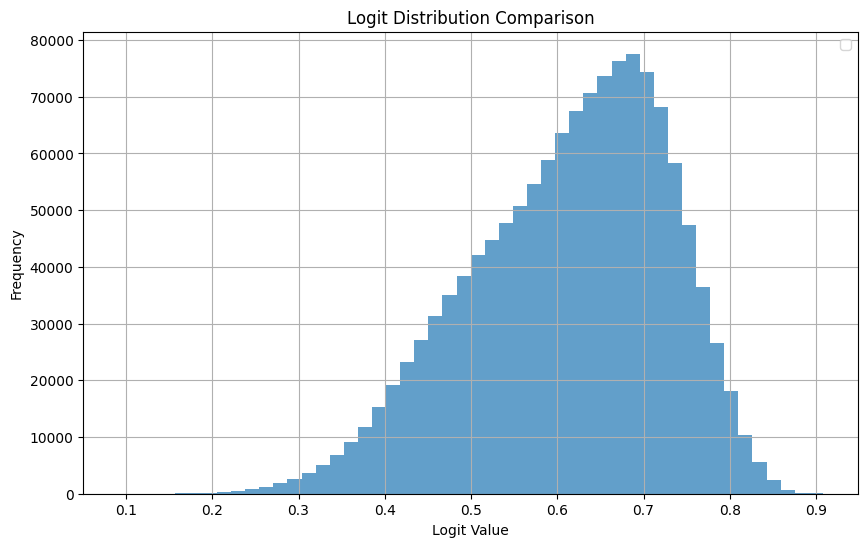

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(sig, bins=50, alpha=0.7)#, label='A: w/ L1 loss')
plt.title('Logit Distribution Comparison')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('logits_comparison.png')
# print("\nSaved logit distribution histogram to 'logit_histogram.png'")

In [13]:
# # logits_a = torch.load("logits_wo_loss.pt").cpu().numpy().flatten()
# logits_a = torch.load("logits_wo_loss.pt").cpu().numpy().flatten()
# logits_b = torch.load("logits_w_l1_loss.pt").cpu().numpy().flatten()
# logits_c = total_logits
# print(f"[A: w/o Add. Loss]Mean: {logits_a.mean():.2f}, Std: {logits_a.std():.2f}, Min: {logits_a.min():.2f}, Max: {logits_a.max():.2f}")
# print(f"[B: w/ L1 Loss] Mean: {logits_b.mean():.2f}, Std: {logits_b.std():.2f}, Min: {logits_b.min():.2f}, Max: {logits_b.max():.2f}")
# print(f"[B: w/ L1 Loss (Dual)] Mean: {logits_c.mean():.2f}, Std: {logits_c.std():.2f}, Min: {logits_c.min():.2f}, Max: {logits_c.max():.2f}")

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.hist(logits_a, bins=50, alpha=0.4, label='A: w/o L')
# plt.hist(logits_b, bins=50, alpha=0.4, label='B: w/ L')
# plt.hist(logits_c, bins=50, alpha=0.4, label='B: w/ L (Dual)')
# plt.title('Logit Distribution Comparison')
# plt.xlabel('Logit Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.savefig('logits_comparison.png')


In [14]:
# sig_a = torch.sigmoid(torch.load("logits_wo_loss.pt")).cpu().numpy().flatten()
# sig_b = torch.sigmoid(torch.load("logits_w_l1_loss.pt")).cpu().numpy().flatten()
# sig_c = torch.sigmoid(torch.load("logits_w_l1_loss_dual.pt")).cpu().numpy().flatten()
# print(f"[A: w/o Add. Loss]Mean: {sig_a.mean():.2f}, Std: {sig_a.std():.2f}, Min: {sig_a.min():.2f}, Max: {sig_a.max():.2f}")
# print(f"[B: w/ L1 Loss] Mean: {sig_b.mean():.2f}, Std: {sig_b.std():.2f}, Min: {sig_b.min():.2f}, Max: {sig_b.max():.2f}")
# print(f"[C: w/ L1 Loss (Dual)] Mean: {sig_c.mean():.2f}, Std: {sig_c.std():.2f}, Min: {sig_c.min():.2f}, Max: {sig_c.max():.2f}")

<!--  -->

In [15]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.hist(sig_a, bins=50, alpha=0.7, label='A: w/o Add. Loss')
# plt.hist(sig_b, bins=50, alpha=0.7, label='B: w/ L1 Loss')
# plt.hist(sig_c, bins=50, alpha=0.7, label='B: w/ L1 Loss (Dual)')
# plt.title('Logit Distribution Comparison')
# plt.xlabel('Logit Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.savefig('logits_comparison.png')
# # print("\nSaved logit distribution histogram to 'logit_histogram.png'")

In [16]:
# 